# Submission

- ensembel CE models (last fc layer)   
15 models (street, top, sentinel)

In [156]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console
from tqdm import tqdm 

In [124]:
#--- all infos
inference_dict ={
    'models':[],
    'folds' :[],
    'data' :[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_21.yaml', 'finetune_20.yaml','finetune_22.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    
    for fold_ in range(cfg.N_SPLIT):        
        inference_dict['cfgs'].append(cfg)
        inference_dict['folds'].append(fold_)
        inference_dict['data'].append(cfg.DATA_TYPE)
        print("Model run version : ", cfg.RUN_VERSION)
        print("Model run fold : ", fold_)
        print("Data type : ", cfg.DATA_TYPE)


Model run version :  33
Model run fold :  0
Data type :  streetview
Model run version :  33
Model run fold :  1
Data type :  streetview
Model run version :  33
Model run fold :  2
Data type :  streetview
Model run version :  33
Model run fold :  3
Data type :  streetview
Model run version :  33
Model run fold :  4
Data type :  streetview
Model run version :  32
Model run fold :  0
Data type :  topview
Model run version :  32
Model run fold :  1
Data type :  topview
Model run version :  32
Model run fold :  2
Data type :  topview
Model run version :  32
Model run fold :  3
Data type :  topview
Model run version :  32
Model run fold :  4
Data type :  topview
Model run version :  34
Model run fold :  0
Data type :  sentinel2
Model run version :  34
Model run fold :  1
Data type :  sentinel2
Model run version :  34
Model run fold :  2
Data type :  sentinel2
Model run version :  34
Model run fold :  3
Data type :  sentinel2
Model run version :  34
Model run fold :  4
Data type :  sentinel2


In [125]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = sorted( os.listdir(train_path) )

names_label = []
for ID in names_data:
    y = int(open(train_path + ID + '/label.txt', "r").read())
    names_label.append(y)


In [126]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [127]:

#--- all the candidates for ensembles based on validation score 

saved_root = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output"
check_points = sorted(os.listdir(saved_root))
target_runs = list(set([ cfg.RUN_VERSION for cfg in inference_dict['cfgs']]))

In [128]:

def find_best_model(target_run_n):
    
    target_runs_0 = [i for i in check_points if str(i.split("_")[0]) == str(target_run_n) ]
    
    best_model_runs = []
    for fold_n in range(0,cfg.N_SPLIT):
        fold_s = [ i for i in target_runs_0 if str(i.split("_")[-5]) == str(fold_n) ]
        #print(fold_s)
        best_model = ""
        best_score = 0
        for fq in fold_s:
            score =  float(fq.split("_")[-3])
            if score > best_score:
                score = best_score
                best_model = fq
        best_model_runs.append(best_model)
    return best_model_runs  

In [129]:
#--- find all 
global_best_models = []
for tg in target_runs:
    fold_best_models = find_best_model(tg)
    global_best_models.extend(fold_best_models)


# Define the categories in the desired order
categories = ['streetview', 'topview', 'sentinel2']

# Create a dictionary to hold lists of file paths for each category
categorized_files = {category: [] for category in categories}

# Categorize the file paths
for path in global_best_models:
    for category in categories:
        if category in path:
            categorized_files[category].append(path)
            break

# Reorder the file paths based on the desired order
ordered_file_paths = []
for category in categories:
    ordered_file_paths.extend(categorized_files[category])

# Print the ordered file paths
for path in ordered_file_paths:
    print(path)

# load weights
ckpt_paths =[ os.path.join(saved_root,i) for i in ordered_file_paths]
for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i])['model'] )

33_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_streetview_CE_fold_0_recall_0.6706_epoch_9.pth
33_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_streetview_CE_fold_1_recall_0.6744_epoch_3.pth
33_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_streetview_CE_fold_2_recall_0.6665_epoch_9.pth
33_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_streetview_CE_fold_3_recall_0.6531_epoch_5.pth
33_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_streetview_CE_fold_4_recall_0.6697_epoch_2.pth
32_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_topview_CE_fold_0_recall_0.6837_epoch_4.pth
32_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_topview_CE_fold_1_recall_0.6871_epoch_8.pth
32_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_topview_CE_fold_2_recall_0.6879_epoch_6.pth
32_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_topview_CE_fold_3_recall_0.6631_epoch_8.pth
32_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_topview_CE_fold_4_recall_0.6958_epoch_7.pth
34_eva02_base_patch14_448.mim_in22k_ft_in22k_

In [130]:
valid_set = map_dataset.Map_Dataset_v14(names_data,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  


idx :  919


5 < Label > 
5 < Model Prediction > 
tensor([[3.5542e-03, 6.4157e-05, 7.6321e-05, 4.9181e-04, 9.2468e-04, 9.9324e-01,
         1.6522e-03]], device='cuda:3')


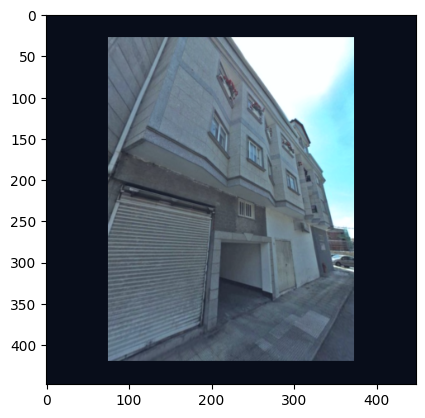

In [131]:
#--- inference
device = "cuda:3"
cfg.DEVICE = device
#--- 

idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
top_view = dataset.__getitem__(idx_)[1]
sentinel2 = dataset.__getitem__(idx_)[2]
img_torch_1 = street_view 
img_torch_2 = top_view
img_torch_3 = sentinel2
loss_type = "CE"

def infer_model_(img_torch_1,model,loss_type):
    with torch.no_grad():
        img_torch_1 = img_torch_1.to(device)
        model = model.to(device)
        model = model.eval()
        img_torch_1 = img_torch_1.unsqueeze(0)
        preds = model(img_torch_1)

        if loss_type == "CE":
            preds_ = preds.softmax(-1).argmax(-1)
        elif loss_type == "MSE" or loss_type == "MAE":
            preds_ = preds
        print(dataset.__getitem__(idx_)[-1], "< Label > ")
        print(preds_.item(), f"< Model Prediction > ")
        #print(preds)
        print(preds.softmax(-1))
        
        img_torch_1 = img_torch_1.squeeze(0)
        img1 = img_torch_1.clone() 
        
        # denormal
        img1 = ((img1) * 0.22) + 0.5
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        #---      
        img1 = img1.permute(1,2,0).cpu()
        img1 = np.asarray(img1)
        
        #---
        # fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,10))
        # ax[0].imshow(img1)
        # ax[1].imshow(img2)
        # ax[2].imshow(img3)
        
        plt.figure()
        plt.imshow(img1)


#----
infer_model_(img_torch_1, inference_dict['models'][0],loss_type)

5 < Label > 
5 < Model Prediction > 
tensor([[0.0054, 0.0047, 0.0072, 0.0047, 0.0294, 0.9137, 0.0348]],
       device='cuda:3')


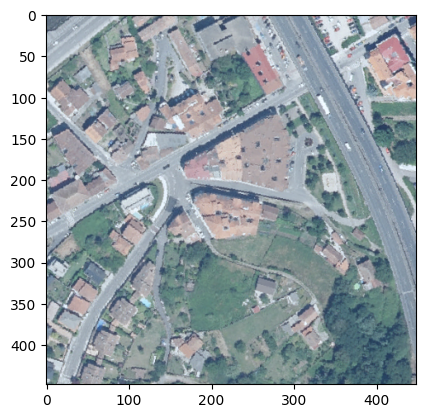

In [132]:
infer_model_(img_torch_2, inference_dict['models'][5],loss_type)

5 < Label > 
5 < Model Prediction > 
tensor([[0.0290, 0.0053, 0.0038, 0.0038, 0.1122, 0.8152, 0.0308]],
       device='cuda:3')


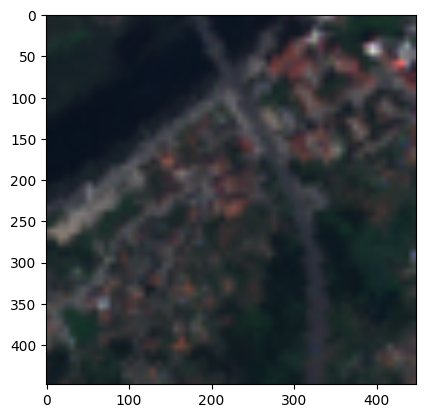

In [133]:
infer_model_(img_torch_3, inference_dict['models'][14],loss_type)

In [134]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_test = os.listdir(test_path)
names_test = sorted(names_test)

In [174]:
submit_df = pd.DataFrame(
    {"idx":[i for i in range(len(names_test))],
     "names_test":names_test,
     "street_view_exists":[False for i in range(len(names_test))],
     "model_0_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_1_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_2_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_3_street_view_prediction" :[[] for i in range(len(names_test))],
     "model_4_street_view_prediction" :[[] for i in range(len(names_test))],

     "model_5_topview_prediction" :[[] for i in range(len(names_test))],
     "model_6_topview_prediction" :[[] for i in range(len(names_test))],
     "model_7_topview_prediction" :[[] for i in range(len(names_test))],
     "model_8_topview_prediction" :[[] for i in range(len(names_test))],
     "model_9_topview_prediction" :[[] for i in range(len(names_test))],

     "model_10_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_11_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_12_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_13_sentinelview_prediction" :[[] for i in range(len(names_test))],
     "model_14_sentinelview_prediction" :[[] for i in range(len(names_test))]
     })


In [175]:
submit_df.head()

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [176]:
for ID in names_test:
    street_file_ = os.path.join( test_path + ID + '/street.jpg')
    if os.path.exists(street_file_):
        submit_df.loc[submit_df['names_test'] == ID, 'street_view_exists'] = True

In [177]:
submit_df.head()

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,True,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]


In [178]:
street_view_names = submit_df.loc[submit_df['street_view_exists'] == True, 'names_test']
street_view_names = sorted(street_view_names)

In [179]:
len(street_view_names)

2167

In [180]:
inference_dict.keys()

dict_keys(['models', 'folds', 'data', 'cfgs', 'predictions', 'labels'])

# 0.Inference for Streetview 

In [181]:
device = "cuda:3"

for model_idx in range(5):
        
    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)
    test_set = map_dataset.Map_Dataset_v14(street_view_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(street_view_names,predictions_)):
        #print(name,pred)
        #pred_ = [i.softmax(-1).argmax(-1).numpy() for i in predictions_][cnt]
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]
        #print(pred_)
        #submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction']._append(pd.DataFrame( np.asarray(pred)) )
        
        Obj = submit_df['names_test'] == name
        idx_true = [ (i,v) for (i,v) in Obj.items() if v == True][0][0]
        #submit_df.loc[idx_true, 'street_view_exists'] = pred_
        submit_df.at[idx_true, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 2167/2167 [01:40<00:00, 21.55it/s]
2167it [00:34, 62.62it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 2167/2167 [01:41<00:00, 21.32it/s]
2167it [00:26, 82.68it/s] 
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe

In [182]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.0031031715, 0.0013235968, 0.0048577497, 0.0...","[0.011685657, 0.016369132, 0.031608272, 0.0309...","[5.088189e-05, 0.00027710065, 0.006388261, 0.9...","[0.00051541947, 0.00021590925, 0.0004192253, 0...","[0.0031585945, 0.003135962, 0.008889828, 0.018...",[],[],[],[],[],[],[],[],[],[]
1,1,22pujdqtiu,True,"[1.9748415e-05, 1.3124229e-05, 7.501227e-05, 3...","[0.014754687, 0.0060526994, 0.021562472, 0.065...","[0.0007514596, 0.0005370499, 0.0016110636, 0.0...","[0.0033573194, 0.001810064, 0.056720234, 0.034...","[0.019395625, 0.007985096, 0.035275307, 0.1321...",[],[],[],[],[],[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
3,3,2435ikdnmf,True,"[0.0004489061, 0.043898527, 0.900784, 0.049258...","[0.0023417869, 0.09032237, 0.8772578, 0.020821...","[0.00013416244, 0.0059783943, 0.98870206, 0.00...","[0.0016123535, 0.9028386, 0.094198525, 0.00069...","[0.011520435, 0.36067304, 0.6050863, 0.0148399...",[],[],[],[],[],[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524,4524,zz33egthkw,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4525,4525,zzfq447gpt,False,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
4526,4526,zzijnoebwv,True,"[0.9902568, 0.009479702, 7.661238e-05, 8.27689...","[0.5900273, 0.22426327, 0.016678276, 0.0031890...","[0.97039527, 0.026623255, 0.001338791, 0.00010...","[0.9598773, 0.037938338, 0.0006891561, 0.00014...","[0.65222776, 0.2994182, 0.018173816, 0.0019510...",[],[],[],[],[],[],[],[],[],[]
4527,4527,zzphni4qma,True,"[0.79485744, 0.19982675, 0.00039676976, 0.0002...","[0.9004126, 0.05168173, 0.0047131767, 0.001178...","[0.2798, 0.033106014, 0.004107311, 0.001279672...","[0.99263436, 0.0015000642, 0.0011058011, 0.000...","[0.6559311, 0.30463627, 0.0295315, 0.002836151...",[],[],[],[],[],[],[],[],[],[]


In [183]:
device = "cuda:3"

infer_names = [i for i in submit_df['names_test']]
for model_idx in range(5,10):

    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)


    #---
    test_set = map_dataset.Map_Dataset_v14(infer_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test",test_mode="top_view_only") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(infer_names,predictions_)):
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]

        submit_df.at[cnt, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [02:37<00:00, 28.67it/s]
4529it [01:24, 53.90it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [02:38<00:00, 28.55it/s]
4529it [01:23, 54.06it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe 

In [184]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.0031031715, 0.0013235968, 0.0048577497, 0.0...","[0.011685657, 0.016369132, 0.031608272, 0.0309...","[5.088189e-05, 0.00027710065, 0.006388261, 0.9...","[0.00051541947, 0.00021590925, 0.0004192253, 0...","[0.0031585945, 0.003135962, 0.008889828, 0.018...","[0.0028907212, 0.0012825705, 0.00447222, 0.197...","[0.0022088368, 0.003730773, 0.032045048, 0.593...","[0.0035253786, 0.007442912, 0.01801434, 0.1288...","[0.0009560791, 0.0027904261, 0.029265314, 0.76...","[0.00082220475, 0.0018138437, 0.015017259, 0.9...",[],[],[],[],[]
1,1,22pujdqtiu,True,"[1.9748415e-05, 1.3124229e-05, 7.501227e-05, 3...","[0.014754687, 0.0060526994, 0.021562472, 0.065...","[0.0007514596, 0.0005370499, 0.0016110636, 0.0...","[0.0033573194, 0.001810064, 0.056720234, 0.034...","[0.019395625, 0.007985096, 0.035275307, 0.1321...","[0.0046213716, 0.010036252, 0.020408409, 0.011...","[0.001023133, 0.023115052, 0.003115693, 0.0046...","[0.0011975453, 0.0046064025, 0.0032648947, 0.0...","[0.0022280854, 0.00069515774, 0.0005600704, 0....","[0.0072359815, 0.007057724, 0.0058815796, 0.00...",[],[],[],[],[]
2,2,23ykackznc,False,[],[],[],[],[],"[0.042999774, 0.38483632, 0.14611615, 0.097781...","[0.011039045, 0.015571323, 0.032631587, 0.8251...","[0.07532917, 0.25516427, 0.26964667, 0.0487688...","[0.0026289762, 0.028683146, 0.2581635, 0.55831...","[0.0028501146, 0.006663395, 0.5200258, 0.19816...",[],[],[],[],[]
3,3,2435ikdnmf,True,"[0.0004489061, 0.043898527, 0.900784, 0.049258...","[0.0023417869, 0.09032237, 0.8772578, 0.020821...","[0.00013416244, 0.0059783943, 0.98870206, 0.00...","[0.0016123535, 0.9028386, 0.094198525, 0.00069...","[0.011520435, 0.36067304, 0.6050863, 0.0148399...","[0.3045877, 0.3783821, 0.21052343, 0.019736666...","[0.22147828, 0.49239138, 0.019514367, 0.076631...","[0.69889563, 0.105084814, 0.013817731, 0.00974...","[0.2575593, 0.678552, 0.009967207, 0.01845324,...","[0.095441505, 0.46711394, 0.30170798, 0.042131...",[],[],[],[],[]
4,4,24akvvheae,False,[],[],[],[],[],"[0.42927355, 0.055000972, 0.093970716, 0.17606...","[0.46133015, 0.046573445, 0.0981251, 0.1455767...","[0.5158614, 0.23100801, 0.11548497, 0.05549460...","[0.22097848, 0.32393584, 0.042085476, 0.193874...","[0.44159856, 0.23656392, 0.07475258, 0.0466191...",[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524,4524,zz33egthkw,False,[],[],[],[],[],"[0.09855354, 0.008251808, 0.2484188, 0.3762306...","[0.03797969, 0.01835289, 0.085712485, 0.647500...","[0.33858007, 0.059581924, 0.29440886, 0.132665...","[0.05579563, 0.014806483, 0.11806822, 0.159660...","[0.0297951, 0.018379247, 0.11822067, 0.6003747...",[],[],[],[],[]
4525,4525,zzfq447gpt,False,[],[],[],[],[],"[0.6121547, 0.042352483, 0.07905196, 0.0325398...","[0.9599149, 0.019694386, 0.005157935, 0.002027...","[0.48142266, 0.3940593, 0.02471345, 0.02388420...","[0.49860758, 0.29749054, 0.011551174, 0.007898...","[0.84884226, 0.10572741, 0.006811522, 0.008885...",[],[],[],[],[]
4526,4526,zzijnoebwv,True,"[0.9902568, 0.009479702, 7.661238e-05, 8.27689...","[0.5900273, 0.22426327, 0.016678276, 0.0031890...","[0.97039527, 0.026623255, 0.001338791, 0.00010...","[0.9598773, 0.037938338, 0.0006891561, 0.00014...","[0.65222776, 0.2994182, 0.018173816, 0.0019510...","[0.41353464, 0.38771877, 0.1421965, 0.00218801...","[0.98451567, 0.0049858387, 0.0016428292, 0.000...","[0.7566406, 0.1816679, 0.013635652, 0.00218229...","[0.9363523, 0.0071345693, 0.0011540545, 0.0015...","[0.32789198, 0.021

In [186]:
submit_df.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v5.csv",index=False)

In [187]:
device = "cuda:3"

infer_names = [i for i in submit_df['names_test']]
for model_idx in range(10,15):

    #--------------------
    if model_idx < 5:
        view_name = "street_view"
    elif 5 <= model_idx < 10:
        view_name = "topview"
    elif 10 <= model_idx:
        view_name = "sentinelview"


    #--------------------
    model = inference_dict['models'][model_idx]
    cfg = inference_dict['cfgs'][model_idx]

    def find_data_config(cfg):
        model = timm.create_model(
        cfg.MODEL,
        pretrained=True,
        num_classes=cfg.CLASSES_NUM )

        #--- data config and transform
        data_config = timm.data.resolve_model_data_config(model)

        return data_config
    #---- 
    data_config = find_data_config(cfg)


    #---
    test_set = map_dataset.Map_Dataset_v14(infer_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test",test_mode="top_view_only") 
    batch_size = 1
    TestLoader = DataLoader(test_set,batch_size,shuffle=False)

    device = "cuda:3"

    #-- Loader train/valid
    Loader = TestLoader

    predictions_ = []
    model = model.to(device) 
    for batch in tqdm(Loader):
        #print("model idx : ", model_idx)
        if model_idx < 5:
            input_img = batch[0].to(device)
        elif 5 <= model_idx < 10:
            input_img = batch[1].to(device)
        elif 10 <= model_idx:
            input_img = batch[2].to(device)

        batch_preds = model(input_img)
        #-- 
        predictions_.extend(batch_preds.detach().cpu())

    #--- insert prediction into DataFrame 
    cnt = 0
    for name, pred in tqdm(zip(infer_names,predictions_)):
        pred_ = [i.softmax(-1).numpy() for i in predictions_][cnt]

        submit_df.at[cnt, f'model_{model_idx}_{view_name}_prediction'] = pred_
        cnt +=1

    #--- check
    #cnt == len(street_view_names)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [02:39<00:00, 28.35it/s]
4529it [01:25, 52.68it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
100%|██████████| 4529/4529 [02:39<00:00, 28.48it/s]
4529it [01:25, 52.97it/s]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe 

In [189]:
submit_df.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v6.csv",index=False)

In [190]:
submit_df

,idx,names_test,street_view_exists,model_0_street_view_prediction,model_1_street_view_prediction,model_2_street_view_prediction,model_3_street_view_prediction,model_4_street_view_prediction,model_5_topview_prediction,model_6_topview_prediction,model_7_topview_prediction,model_8_topview_prediction,model_9_topview_prediction,model_10_sentinelview_prediction,model_11_sentinelview_prediction,model_12_sentinelview_prediction,model_13_sentinelview_prediction,model_14_sentinelview_prediction
0,0,22mhjewvtj,True,"[0.0031031715, 0.0013235968, 0.0048577497, 0.0...","[0.011685657, 0.016369132, 0.031608272, 0.0309...","[5.088189e-05, 0.00027710065, 0.006388261, 0.9...","[0.00051541947, 0.00021590925, 0.0004192253, 0...","[0.0031585945, 0.003135962, 0.008889828, 0.018...","[0.0028907212, 0.0012825705, 0.00447222, 0.197...","[0.0022088368, 0.003730773, 0.032045048, 0.593...","[0.0035253786, 0.007442912, 0.01801434, 0.1288...","[0.0009560791, 0.0027904261, 0.029265314, 0.76...","[0.00082220475, 0.0018138437, 0.015017259, 0.9...","[0.0062458883, 0.0029877813, 0.007969532, 0.05...","[0.09382133, 0.009088115, 0.025352376, 0.18960...","[0.13069223, 0.06382789, 0.65625954, 0.0397339...","[0.014009041, 0.0081094345, 0.017782573, 0.627...","[0.02069587, 0.029139215, 0.047436774, 0.13175..."
1,1,22pujdqtiu,True,"[1.9748415e-05, 1.3124229e-05, 7.501227e-05, 3...","[0.014754687, 0.0060526994, 0.021562472, 0.065...","[0.0007514596, 0.0005370499, 0.0016110636, 0.0...","[0.0033573194, 0.001810064, 0.056720234, 0.034...","[0.019395625, 0.007985096, 0.035275307, 0.1321...","[0.0046213716, 0.010036252, 0.020408409, 0.011...","[0.001023133, 0.023115052, 0.003115693, 0.0046...","[0.0011975453, 0.0046064025, 0.0032648947, 0.0...","[0.0022280854, 0.00069515774, 0.0005600704, 0....","[0.0072359815, 0.007057724, 0.0058815796, 0.00...","[0.102176815, 0.026556978, 0.014759781, 0.0425...","[0.15088789, 0.043643624, 0.092549495, 0.02310...","[0.13269809, 0.14882073, 0.16869062, 0.0411398...","[0.4160717, 0.22972713, 0.16694339, 0.01270842...","[0.22831246, 0.024191016, 0.014113845, 0.02180..."
2,2,23ykackznc,False,[],[],[],[],[],"[0.042999774, 0.38483632, 0.14611615, 0.097781...","[0.011039045, 0.015571323, 0.032631587, 0.8251...","[0.07532917, 0.25516427, 0.26964667, 0.0487688...","[0.0026289762, 0.028683146, 0.2581635, 0.55831...","[0.0028501146, 0.006663395, 0.5200258, 0.19816...","[0.1290924, 0.14247839, 0.20077193, 0.4641308,...","[0.50280803, 0.09955483, 0.20975962, 0.1590959...","[0.3854996, 0.25326052, 0.17108199, 0.15492788...","[0.65019494, 0.022840712, 0.02724326, 0.118919...","[0.49817657, 0.28736433, 0.06575625, 0.0747568..."
3,3,2435ikdnmf,True,"[0.0004489061, 0.043898527, 0.900784, 0.049258...","[0.0023417869, 0.09032237, 0.8772578, 0.020821...","[0.00013416244, 0.0059783943, 0.98870206, 0.00...","[0.0016123535, 0.9028386, 0.094198525, 0.00069...","[0.011520435, 0.36067304, 0.6050863, 0.0148399...","[0.3045877, 0.3783821, 0.21052343, 0.019736666...","[0.22147828, 0.49239138, 0.019514367, 0.076631...","[0.69889563, 0.105084814, 0.013817731, 0.00974...","[0.2575593, 0.678552, 0.009967207, 0.01845324,...","[0.095441505, 0.46711394, 0.30170798, 0.042131...","[0.815429, 0.08164514, 0.03485297, 0.017543836...","[0.52539486, 0.22184399, 0.015013367, 0.016064...","[0.2216932, 0.55494523, 0.13709095, 0.00915769...","[0.32774016, 0.62011784, 0.0190558, 0.00991820...","[0.21385325, 0.7087376, 0.049134865, 0.0045580..."
4,4,24akvvheae,False,[],[],[],[],[],"[0.42927355, 0.055000972, 0.093970716, 0.17606...","[0.46133015, 0.046573445, 0.0981251, 0.1455767...","[0.5158614, 0.23100801, 0.11548497, 0.05549460...","[0.22097848, 0.32393584, 0.042085476, 0.193874...","[0.44159856, 0.23656392, 0.07475258, 0.0466191...","[0.58372635, 0.097580396, 0.062289856, 0.16120...","[0.69222724, 0.1290936, 0.075643346, 0.0560977...","[0.5505392, 0.27845308, 0.094322175, 0.0487683...","[0.49346054, 0.06945816, 0.14974926, 0.1762441...","[0.72452384, 0.11452592, 0.07810863, 0.0445195...

In [225]:
tmp_ = []
for i,row in submit_df.iterrows():
    #print(row['street_view_exists'])
    
    if row['street_view_exists'] == True:
        #print(row.values[3:])
        result_ = sum( row.values[3:] ) / len(row.values[3:]) 
        tmp_.append(result_)
    else:
        result_ = sum( row.values[8:] ) / len(row.values[8:]) 
        tmp_.append(result_)


In [227]:
result_.__len__()

7

In [228]:
tmp_.__len__()

4529

In [229]:
sub_file = pd.read_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_v3.csv") 

In [231]:
sub_file

,country_id,pid,city_id,predicted_label
0,QCD,22mhjewvtj,YPGHW,4
1,QCD,22pujdqtiu,YPGHW,5
2,FMW,23ykackznc,7PNBD,3
3,QCD,2435ikdnmf,YPGHW,1
4,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
4524,FMW,zz33egthkw,7PNBD,0
4525,PNN,zzfq447gpt,B2MVH,0
4526,QCD,zzijnoebwv,YPGHW,0
4527,QCD,zzphni4qma,YPGHW,1


In [232]:
sub_file['predicted_label'] = [ np.argmax(i) for i in tmp_]

In [233]:
sub_file

,country_id,pid,city_id,predicted_label
0,QCD,22mhjewvtj,YPGHW,4
1,QCD,22pujdqtiu,YPGHW,5
2,FMW,23ykackznc,7PNBD,3
3,QCD,2435ikdnmf,YPGHW,1
4,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
4524,FMW,zz33egthkw,7PNBD,3
4525,PNN,zzfq447gpt,B2MVH,0
4526,QCD,zzijnoebwv,YPGHW,0
4527,QCD,zzphni4qma,YPGHW,1


In [235]:
sub_file.to_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/ensemble_15_models_v1.csv",index=False)